## Se importan las librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
from math import sqrt
import time
#from numba import njit, jit

In [41]:
# Importar esta libreria si se quiere trabajar con root
import ROOT
from ROOT import TCanvas, TFile, TPaveText
from ROOT import gROOT, gBenchmark

Welcome to JupyROOT 6.26/06


## Se importa el csv
La segunda y tercera línea coméntenla la primera vez que importen los datos, para así puedan determinar cuántas filas no correponden a los datos que necesitamos.


In [3]:
nombre = '14juniodatos_003.csv'

imagen = '14juniodatos_003.png'
#nombre_pedestal = '/content/drive/MyDrive/a/14juniopedestal_003.csv'
#imagen_pedestal = '14juniopedestal_003.png'

In [4]:
df = pd.read_csv(nombre, sep = ',', header = None,
                skiprows = [0,1,2,3,4,5,6,7,8,9,10], #No se importan las filas 0 a 10
                 names = ['tiempo', 'voltaje'], #Se le agrega un nombre a cada columna
                 dtype = np.float64) #Se elige el tipo de dato para importar los datos, 
    #para este caso usamos float64 ya que este tipo de dato es decimal y puede alcanzar grandes números
    #el  número máximo que puede alcanzar es 2⁶⁴ - 1.

#### Transformamos las columnas a arreglos de numpy

In [5]:
t = np.array(df['tiempo'].to_numpy())  # convertimos las columnas en arreglos de numpy
v = np.array(df['voltaje'].to_numpy())

Se cuenta la cantidad de datos por pulso

In [6]:
for i in range(len(v)):
    if t[i] > 0:
        #print(i)
        for j in range(len(v)):
            if t[j+i] < 0:
                print(j+i)
                datos_por_pulso = j+i
                break
        break

1000


In [7]:
df.isnull().values.any() #comprobar si hay variables NaN en el dataframe

False

In [8]:
# Conocer el valor máximo de voltaje y las veces que se repite este valor
print("El valor máximo de voltaje es: ", v.min())
print("Las veces que se repite este valor es: ",list(v).count(min(v)))
#print(list(v).index(v.min()))
#print(list(y).count(0.0323125))

El valor máximo de voltaje es:  -0.0476
Las veces que se repite este valor es:  2


Se cuenta la cantidad de pulsos que hay:

In [9]:
filas = len(t)
numero = filas/datos_por_pulso # Variable numero: cantidad de pulsos
print("La cantidad de pulsos es :", numero)

La cantidad de pulsos es : 10000.0


## Visualizamos los datos

Gráficamos una medición para revisar que esté todo en orden

In [10]:
figure(figsize=(16, 9), dpi=800)
n = 0 # número del pulso que se quiere graficar
plt.plot(t[datos_por_pulso*n:datos_por_pulso*n+datos_por_pulso],
         v[datos_por_pulso*n:datos_por_pulso*n+datos_por_pulso]) #el valor de la izquierda a indica donde comienza la lista y el lado derecho donde termina

plt.ylabel('Voltaje [V]') # Títulos de los ejes.
plt.xlabel('Tiempo [s]')

plt.title('Gráfico de la muestra') #Título del gráfico
plt.show()

## Cálculo offset, para realizar corrección de offset

In [11]:
inf = int(datos_por_pulso*0.15) #Selecciona los valores de la lista que se quieren utilizar para calcular el offset
sup = int(datos_por_pulso*0.85)

In [12]:
def seccionar(v, i,inf,sup):
    indice_0 = datos_por_pulso*i
    indice_menor = (datos_por_pulso * i) + inf
    indice_mayor = (datos_por_pulso * i) + sup
    indice_final = (datos_por_pulso * i) + datos_por_pulso
    
    lista_izq = v[indice_0:indice_menor]
    lista_der = v[indice_mayor:indice_final]
    lista_completa = v[indice_0:indice_final]
    
    return lista_izq, lista_der, lista_completa

In [13]:
def offset(lista_completa, vo, menosoff):
    return lista_completa - vo*menosoff


In [14]:
def voltaje_corregido(v, numero):
    menosoff = np.asfarray([1 for x in range(datos_por_pulso)])
    VV = np.asfarray([], np.float64)
    Vrms = np.asfarray([], np.float64)
    Voff = np.asfarray([], np.float64)
    
    for i in range(int(numero)):
        
        lista_izq, lista_der, lista_completa = seccionar(v, i,inf,sup)
        
  
        vo_izq = sum(lista_izq)/len(lista_izq)
        vo_der = sum(lista_der)/len(lista_der)
        if abs(vo_izq) < abs(vo_der):

            Voff = np.append(Voff, vo_izq)
            VV = np.concatenate((VV, offset(lista_completa, vo_izq, menosoff)))
        else:

            Voff = np.append(Voff, vo_der)
            VV = np.concatenate((VV, offset(lista_completa, vo_der, menosoff)))

    return VV, Vrms, Voff

In [15]:
tiempo_inicial = time.time()
v, Vrms, Voff = voltaje_corregido(v, numero)

tiempo_final = time.time() - tiempo_inicial

In [23]:
print(tiempo_final) # cuánto tardó el programa en ejecutarse

65.26507449150085


In [27]:
#Se calcula nuevamente el offset, pero de los datos corregidos, y con esto comparar el offset viejo con el nuevo
nuevoOffset = []
for i in range(int(numero)):
    indV0 = datos_por_pulso*i
    indV400 = datos_por_pulso * i + inf
    indV850 = datos_por_pulso * i + sup
    indV1250 = datos_por_pulso * i + datos_por_pulso
    
    Vrms400 = v[indV0:indV400]
    Vrms850 = v[indV850:indV1250]
    VV1250 = v[indV0:indV1250]
    
    voffn = sum(Vrms400)/len(Vrms400)
    voffn2 =  sum(Vrms850)/len(Vrms850)
    if abs(voffn) < abs(voffn2):
        nuevoOffset.append(voffn)
    else:
        
        nuevoOffset.append(voffn2)

### Comparación offset viejo y offset nuevo

In [29]:
eq = range(0,int(numero)) #Se crea una lista para el eje x del gráfico
figure(figsize=(16, 9), dpi=800) #Se define el tamaño del gráfico


plt.scatter(eq, Voff, s = 4, color = 'blue', label = 'Offset')
plt.scatter(eq, nuevoOffset, s = 4, color = 'green', label = 'Nuevo offset')
#plt.plot(t2, listaPromRMS, color = 'k', lw = 3, ls = '--', label = 'Promedio RMS')
#plt.ylim(-1,1)
#plt.xlim(10,40)
plt.xlabel("Número de pulso")
plt.ylabel("Valor de offset")
plt.title("Comparación offset y nuevo offset")
plt.legend()
plt.grid()
plt.show()

##### Insertar los valores de los índices encontrados anteriormente

In [30]:
v = list(v)
print(v.index(min(v))/datos_por_pulso)
pulso_maximo = v.index(min(v))/datos_por_pulso # indica el pulso donde se encuentra el peak máximo de voltaje

8755.418


In [34]:
#el valor izquierda a indica donde comienza la lista y el valor derecha donde termina
#el valor npulso, el número da cada pulso

izquierda = 0 # izquierda y derecha indican los índices que consideraremos para calcular las integrales
derecha = datos_por_pulso # Cambiar valores de izquierda y derecha por si se requiere acotar el pulso
npulso = int(pulso_maximo)

In [35]:
#Se grafica con los indices ingresados
%matplotlib inline
figure(figsize=(16, 9), dpi=800)
plt.plot(t[datos_por_pulso*npulso + izquierda : datos_por_pulso*npulso + derecha] , 
         v[datos_por_pulso*npulso + izquierda : datos_por_pulso*npulso + derecha])
plt.ylabel('Voltaje [V]') 
plt.xlabel('Tiempo [s]')

plt.title('Gráfico de la muestra') 
plt.show()

#### Se calculan las integrales

In [37]:
integrales = []  #lista que contiene los valores de cada integral
for i in range(int(numero)):
    
    #Para indexar se utiliza xx e yy

    xx = datos_por_pulso * i + izquierda
    yy = (datos_por_pulso * i) + derecha
     
    xss = list(t[xx:yy]) # yss y xss son las listas indexadas a la cual se le calculará la integral
    yss = list(v[xx:yy])
    tiempo = xss[1] - xss[0]
    #print(tiempo)
    
    integrales.append(-1*(sum(yss)*tiempo/50))

#### Histograma utilizando matplotlib

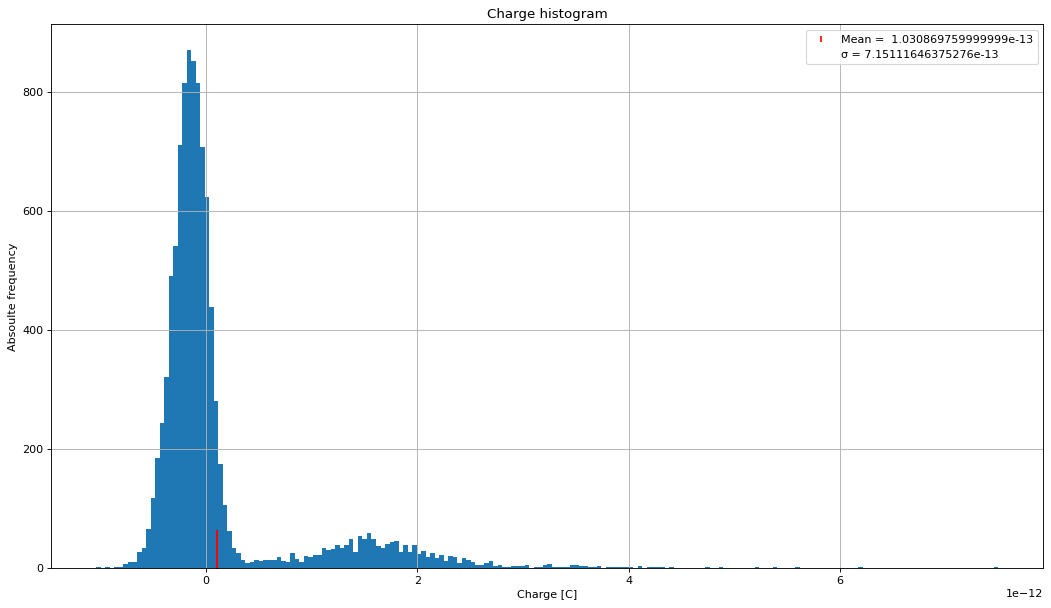

In [39]:
%matplotlib inline
figure(figsize=(16, 9), dpi=80)

histograma_integrales = plt.hist(integrales, bins = 200)
plt.ylabel('Absoulte frequency')
plt.xlabel('Charge [C]')
#plt.xlim(0,0.5*10**(-12))
media1 = [np.mean(integrales) for x in range(60)]
vay1 = [x for x in range(0, 60)]

plt.scatter(media1, vay1, c = 'red', marker = '|', label = f"Mean =  {np.mean(integrales)}")
plt.plot([], [], ' ', label=f"σ = {np.std(integrales)}")
plt.grid()
plt.legend()
plt.title("Charge histogram")
plt.savefig(imagen, facecolor = 'lavender')
plt.show()

In [42]:
%jsroot on

In [45]:
c1 = ROOT.TCanvas("c1","Histograma root",800,600)
hist = ROOT.TH1D("integrales","Histrogram of the charge",586,-5*10**-(12),8.5*10**(-12))
for i in range(len(integrales)):
    hist.Fill(integrales[i])
#hist.SetFillColor(0)
#hist.Fit('gaus')
hist.Draw()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: integrales (Potential memory leak).
